Nama     : Yona Ade Hermawan

---


Email    : yonaadehermawan@gmail.com

---


Domisili : Magelang

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yonaadehermawan","key":"376c7d0fa449c9d190796dbba24ba41b"}'}

In [3]:
!ls ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 671M/675M [00:03<00:00, 239MB/s]
100% 675M/675M [00:03<00:00, 223MB/s]


In [5]:
import tensorflow as tf
import zipfile,os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# melakukan ekstraksi pada file zip
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [6]:
base_dir = '/tmp/cell_images/cell_images'
train_dir = '/content/output/train'
validation_dir = '/content/output/val'

In [39]:
!pip install split-folders
import splitfolders

splitfolders.ratio(base_dir, output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

Copying files: 27560 files [00:07, 3846.95 files/s]


In [42]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 22046 images belonging to 2 classes.
Found 11024 images belonging to 2 classes.


In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [53]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai > 92%!")
      self.model.stop_training = True
callbacks = myCallback()


In [54]:
train_model = model.fit(
      train_generator,
      steps_per_epoch=25,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[callbacks])

Epoch 1/20
25/25 - 6s - loss: 0.7132 - accuracy: 0.5175 - val_loss: 0.6885 - val_accuracy: 0.6250
Epoch 2/20
25/25 - 5s - loss: 0.6920 - accuracy: 0.5300 - val_loss: 0.6884 - val_accuracy: 0.5063
Epoch 3/20
25/25 - 5s - loss: 0.6769 - accuracy: 0.5788 - val_loss: 0.7012 - val_accuracy: 0.4875
Epoch 4/20
25/25 - 5s - loss: 0.6362 - accuracy: 0.6475 - val_loss: 0.7802 - val_accuracy: 0.5688
Epoch 5/20
25/25 - 5s - loss: 0.5961 - accuracy: 0.7262 - val_loss: 0.5827 - val_accuracy: 0.7188
Epoch 6/20
25/25 - 5s - loss: 0.6366 - accuracy: 0.6725 - val_loss: 0.5501 - val_accuracy: 0.8250
Epoch 7/20
25/25 - 5s - loss: 0.4711 - accuracy: 0.8012 - val_loss: 0.3784 - val_accuracy: 0.8562
Epoch 8/20
25/25 - 5s - loss: 0.2801 - accuracy: 0.8988 - val_loss: 0.2763 - val_accuracy: 0.9375
Epoch 9/20
25/25 - 5s - loss: 0.2481 - accuracy: 0.9200 - val_loss: 0.4176 - val_accuracy: 0.8875

Akurasi telah mencapai > 92%!


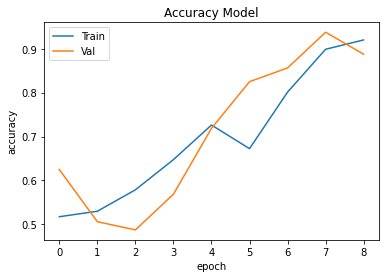

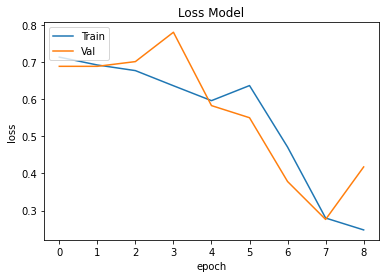

In [55]:
import matplotlib.pyplot as plt

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()  
#Loss
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpasw1x65v/assets


INFO:tensorflow:Assets written to: /tmp/tmpasw1x65v/assets


In [58]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)